In [16]:
import numpy as np
import pandas as pd
import scipy
from scipy.linalg import expm
from scipy.misc import toimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#Qiskit Set
from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

In [43]:
#def Breast_cancer(training_size, test_size, n, PLOT_DATA):

training_size=20
test_size=10
n=6
PLOT_DATA=True

In [44]:
#Load DataSet

class_labels = [r'A', r'B']

# Credit

CC_df=pd.read_csv('UCI_Credit_Card.csv', sep=',')

CC_target=CC_df['default.payment.next.month'].values
CC_df=CC_df.drop(['default.payment.next.month'], axis=1)
CC_data=CC_df.values

print(">> Shape of Credit Card dataset: "+str(CC_data.shape)+", Shape of Target: "+str(CC_target.shape))

>> Shape of Credit Card dataset: (30000, 23), Shape of Target: (30000,)


In [45]:
CC_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [46]:
sample_train, sample_test, label_train, label_test = train_test_split(CC_data, CC_target, test_size=0.20, random_state=12)

print(">> Shape of sample train: "+str(sample_train.shape)+", Shape of sample test: "+str(sample_test.shape))

>> Shape of sample train: (24000, 23), Shape of sample test: (6000, 23)


In [47]:
# Now we standarize for gaussian around 0 with unit variance
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [48]:
sample_train[1]

array([-0.520584  , -1.24008173,  0.18590253, -1.05419699,  0.70656115,
        0.01578468,  0.11319109,  0.13764758,  0.18493656,  0.23196724,
        0.25222204,  0.66193279,  0.62406562,  0.59477358,  0.58100544,
        0.56460585,  0.4875931 , -0.13822209, -0.08239435, -0.13691494,
       -0.09968343, -0.12344716, -0.27695333])

In [49]:
sample_test[1]

array([ 0.01786839, -1.24008173,  0.18590253,  0.85890152, -0.70479695,
        0.90506247, -1.56474974, -1.53630318, -1.52447127, -1.53400063,
       -1.49477042, -0.69510131, -0.69075318, -0.67812044, -0.67269172,
       -0.66169649, -0.6522335 , -0.33477135, -0.25411943, -0.29065349,
       -0.31180365, -0.31359429, -0.29602613])

In [50]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=n).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print(">> Shape of reduced sample train: "+str(sample_train.shape)+", Shape of reduced sample test: "+str(sample_test.shape))

>> Shape of reduced sample train: (24000, 6), Shape of reduced sample test: (6000, 6)


In [51]:
pca

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

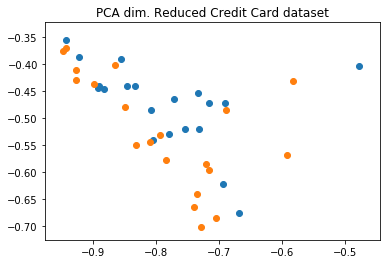

In [52]:
# Scale to the range (-1,+1)
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Pick training size number of samples from each distro
training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)}

if PLOT_DATA:
    for k in range(0, 2):
        plt.scatter(
            sample_train[label_train == k, 0][:training_size],
            sample_train[label_train == k, 1][:training_size]
        )

    plt.title("PCA dim. Reduced Credit Card dataset")
    plt.show()

#return sample_train, training_input, test_input, class_labels

In [53]:
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)

from qiskit import IBMQ
IBMQ.save_account('2670c486a8792dff6c5327a9729c669ffe3fe33b5970cb3b5c1fd8662121db289092e7eb6d2525215d9d0e17808cf25599b7da660807e30e2c3409e302bfb2f5', 'https://api.quantum-computing.ibm.com/api/Hubs/ibm-q/Groups/open/Projects/main')

IBMQ.load_accounts()

#backend = IBMQ.get_backend('ibmq_5_yorktown')
#print("Running on device: ", backend)

C:\Users\darsh\Anaconda3\lib\site-packages\qiskit\providers\ibmq\credentials\configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '
C:\Users\darsh\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqprovider.py:272: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [57]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=n, depth=1, entanglement='linear')
qsvm = QSVM.(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
#backend = IBMQ.get_backend('ibmq_5_yorktown')

print("Running on device: ", backend)

quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)


2019-06-10 13:49:22,197:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "depth": 1,
    "entanglement": "linear",
    "entangler_map": null
}
2019-06-10 13:49:22,201:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "Second_Order_Expansion_schema",
    "properties": {
        "depth": {
            "default": 2,
            "minimum": 1,
            "type": "integer"
        },
        "entanglement": {
            "default": "full",
            "oneOf": [
                {
                    "enum": [
                        "full",
                        "linear"
                    ]
                }
            ],
            "type": "string"
        },
        "entangler_map": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-06-10 13:49:22,202:qiskit.aqua.parser.json_sc

Running on device:  qasm_simulator


|██████████████████████████████████████████████████| 780/780 [00:00:00:00]
2019-06-10 13:49:33,968:qiskit.aqua.utils.run_circuits:INFO: Circuit cache is empty, compiling from scratch.
2019-06-10 13:50:17,469:qiskit.aqua.algorithms.many_sample.qsvm.qsvm:DEBUG: Calculating overlap:
|██████████████████████████████████████████████████| 780/780 [00:00:00:00]
2019-06-10 13:50:18,314:qiskit.aqua.utils.qp_solver:DEBUG: Solving QP problem is completed.
2019-06-10 13:50:18,317:qiskit.aqua.algorithms.many_sample.qsvm.qsvm:DEBUG: Building circuits:
|██████████████████████████████████████████████████| 340/340 [00:00:00:00]
2019-06-10 13:50:29,410:qiskit.aqua.algorithms.many_sample.qsvm.qsvm:DEBUG: Calculating overlap:
|██████████████████████████████████████████████████| 340/340 [00:00:00:00]
2019-06-10 13:50:29,839:qiskit.aqua.algorithms.many_sample.qsvm._qsvm_binary:DEBUG: Classification success for this set is 60.00% 



In [55]:
print("Testing success ratio: {}".format(result['testing_accuracy']))


Testing success ratio: 0.8
